In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, rank, desc, sum, max
from pyspark.sql import Window
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("last-year-top-spending-customers").getOrCreate()

22/08/19 08:38:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
orders_df = spark.read.option("inferSchema", "True").option("header", "true") \
                      .csv("/home/jovyan/work/notebooks/ecommerce_data/olist_orders_dataset.csv")
customers_df = spark.read.option("inferSchema", "True").option("header", "true") \
                         .csv("/home/jovyan/work/notebooks/ecommerce_data/olist_customers_dataset.csv")
payments_df = spark.read.option("inferSchema", "True").option("header", "true") \
                        .csv("/home/jovyan/work/notebooks/ecommerce_data/olist_order_payments_dataset.csv")

In [4]:
df = orders_df.agg(max(year("order_approved_at")).alias("a"))
n = df.toPandas().to_string()
last_year = int(n[11:15]) - 1
window = Window.partitionBy("month").orderBy(desc("total"))
df10 = orders_df.join(payments_df, payments_df.order_id == orders_df.order_id).drop(payments_df.order_id) \
                .join(customers_df, customers_df.customer_id == orders_df.customer_id).drop(orders_df.customer_id) \
                .filter(year("order_approved_at") == last_year) \
                .groupBy(["customer_unique_id", month("order_approved_at").alias("month")]) \
                .agg(sum("payment_value").alias("total")).orderBy(desc("total")).withColumn("rank", rank().over(window)) \
                .filter(col('rank') == 1).select("customer_unique_id", "month", "total").orderBy("month")

In [5]:
df10.toPandas()

,customer_unique_id,month,total
0,ee2bb06c1d3f368e92084edefb7e4b57,1,3016.01
1,dc4802a71eae9be1dd28f5d788ceb526,2,6929.31
2,011875f0176909c5cf0b14a9138bb691,3,4016.91
3,da122df9eeddfedc1dc1f5349a1a690c,4,7571.63
4,ff4159b92c40ebe40454e3e6a7c35ed6,5,6726.66
5,ff0ae98646e7bbb41cf0f0d3991fef98,6,3048.27
6,6172bd5b7f52ade8c6c4548b448ff54f,7,3041.73
7,60b2ec19b8c18082cdb5180106a97cb5,8,2692.82
8,58c1b085b54c03a1f1ab5f13d64c2b1c,9,3064.72
9,0a0a92112bd4c708ca5fde585afaa872,10,13664.08


In [6]:
data = [int(i * 100) / 100 for i in df10.select("total").orderBy(desc("month")).rdd.flatMap(lambda x: x).collect()]
cust = df10.select("customer_unique_id").orderBy(desc("month")).rdd.flatMap(lambda x: x).collect()
months = ['December', 'November', 'October', 'September',  'August', 'July', 
          'June', 'May',  'April', 'March', 'February', 'January']

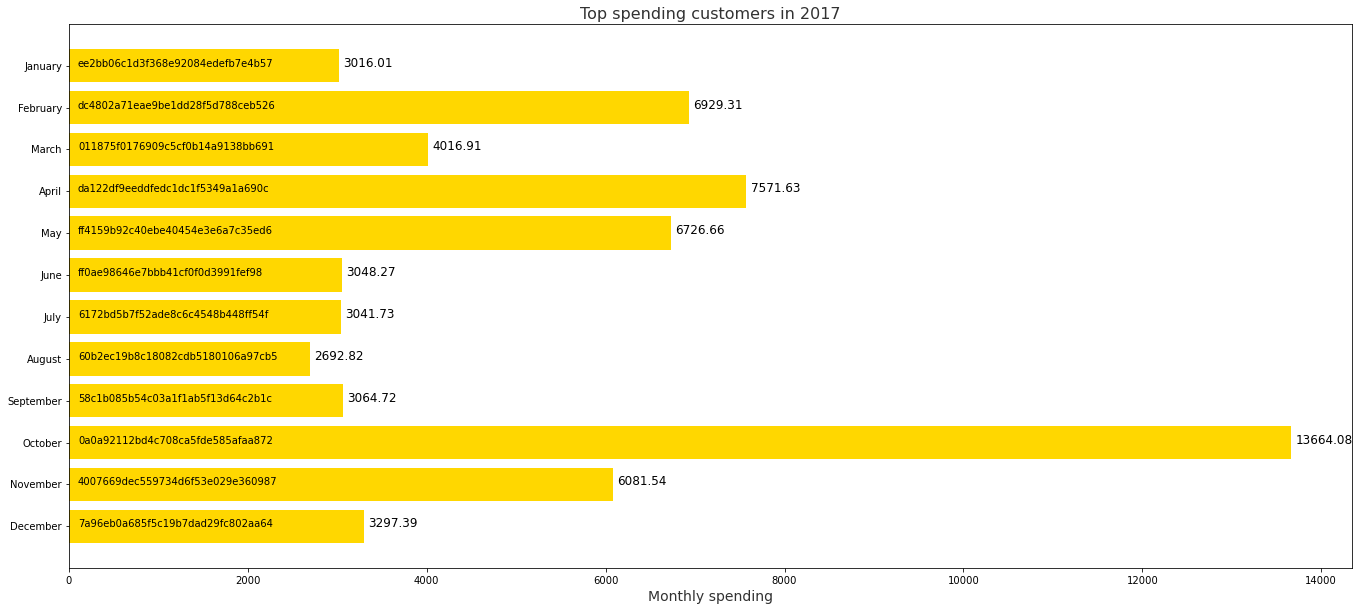

In [7]:
y_pos = np.arange(len(data))
 
plt.figure(figsize=(23,10))
 
plt.barh(y_pos, data, color = 'gold')

plt.yticks(y_pos, months, va="center")
 
plt.xlabel('Monthly spending', fontsize=14, color='#323232')
plt.title('Top spending customers in ' + str(last_year), fontsize=16, color='#323232')

for i in range(len(cust)):
    plt.text(100, i, cust[i], color = "black", fontsize = 10)
    plt.text(data[i] + 50, i, data[i], color = "black", fontsize = 12)
##
plt.show()